In [1]:
import pandas as pd
import numpy as np
from glob import glob 
import sys
sys.path += ["../src"]
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots as sbp
from sklearn.preprocessing import StandardScaler
import pickle


In [2]:
def get_df_bins(df_, df_real, bin_size = 0.01):
    df = df_.copy()

    bins_x = np.arange(df_real["x"].min() - bin_size / 2, df_real["x"].max() + bin_size / 2, bin_size)
    bins_y = np.arange(df_real["y"].min() - bin_size / 2, df_real["y"].max() + bin_size / 2, bin_size)

    df["bin_x"] = pd.cut(df["x"], bins = bins_x, labels = np.arange(len(bins_x)-1))
    df["bin_y"] = pd.cut(df["y"], bins = bins_y, labels = np.arange(len(bins_y)-1))
    df.drop(columns = ["x", "y"], inplace = True)

    return df


In [3]:
all_geo_features = {}

for file in sorted(glob(f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_*.pickle')):
    prov = file.split(".")[-2][-2:]
    if prov == "FE":
        break
    all_geo_features[prov] = {}

    with open(file, 'rb') as f:
        data = pickle.load(f)

    df_real = get_df_bins(data["df_real"].copy(), data["df_real"])
    for k in data:
        if "95" not in k:
            df_k = get_df_bins(data[k], data["df_real"])
            dist = np.abs((df_real.groupby(["bin_x", "bin_y"]).mean() - df_k.groupby(["bin_x", "bin_y"]).mean()).dropna()).sum(axis = 1).mean()
            all_geo_features[prov][k] = dist

            

In [9]:
df_geo_features = pd.DataFrame(all_geo_features)
df_geo_features.to_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_grid_geo_features_isp.csv")
df_geo_features = pd.read_csv(f"/data/housing/data/intermediate/jl_pop_synth/similarity_grid_geo_features_isp.csv", index_col = 0)
df_geo_features = df_geo_features.drop("df_real").apply(lambda x: (x - x.mean()) / (x.std() + 0.0001))


In [5]:
df_geo_features.T.mean().sort_values()

df_nfvae                   -1.196934
df_copula_nf               -0.903626
df_shuffle_cap_num         -0.545905
df_shuffle_cap_bins        -0.272316
df_copula_ablation          0.082183
df_ablation                 0.490251
df_shuffle_province_num     0.905107
df_shuffle_province_bins    1.341128
dtype: float64

<Axes: >

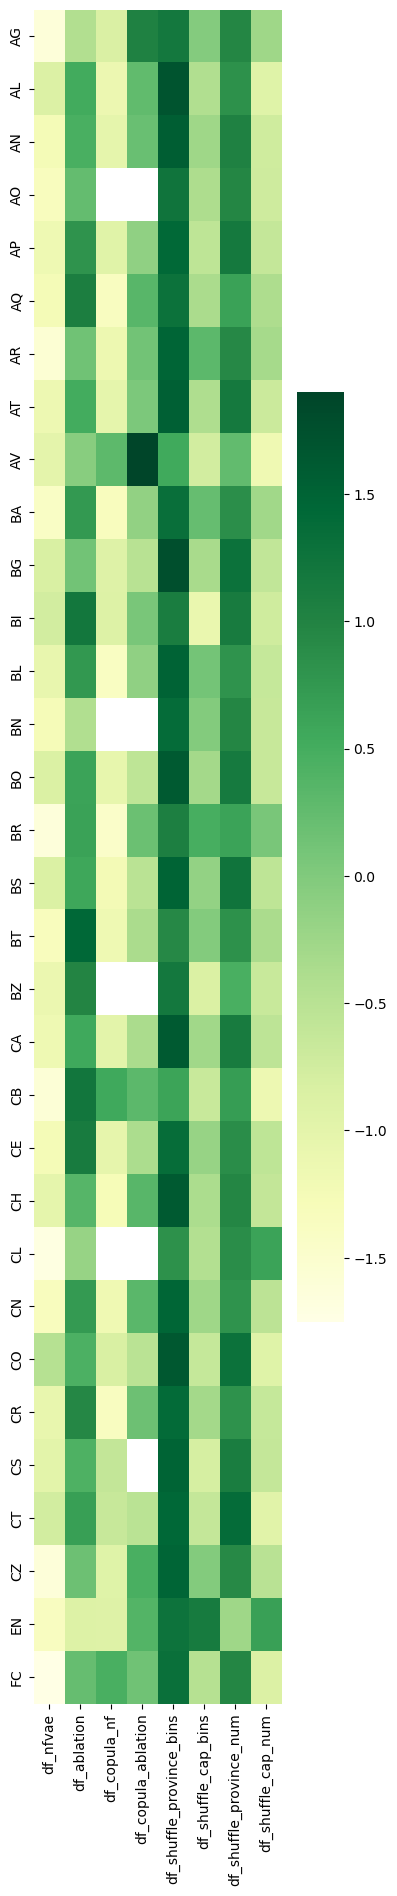

In [6]:
fig, axes = sbp(figsize = (4,22))

sns.heatmap(df_geo_features.T, cmap = "YlGn")

<Axes: xlabel='distance', ylabel='method'>

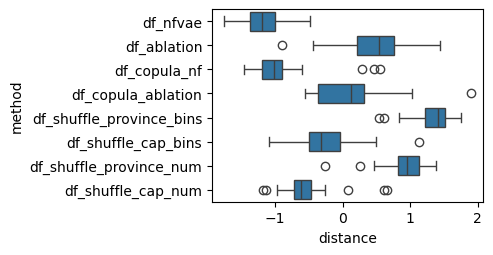

In [7]:
fig, axes = sbp(figsize = (3.5, 2.5))

sns.boxplot(data = df_geo_features.stack().reset_index().rename(columns = {"level_0": "method", 0: "distance"}), y = "method", x = "distance")